In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
interval = '1d'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [83]:
btc_1d_data = pd.read_csv(f'data/btc_1d_data_with_ma.csv', index_col=False)
btc_1d_data['timestamp'] = pd.to_datetime(btc_1d_data['timestamp'])

In [89]:
# ma_1d_candidates = [100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
# ma_1d_candidates = [100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220]#, 230, 240, 250, 260, 270, 280, 290, 300]
# ma_candidates = [230, 240, 250, 260, 270, 280, 290, 300]
ma_candidates = [x for x in range(40, 210, 10)]

In [85]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

btc_data_2022 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2022])]
btc_data_2022 = btc_data_2022.drop(btc_data_2022[~pd.to_datetime(btc_data_2022['timestamp']).dt.year.isin([2022])].index)
btc_data_2022 = btc_data_2022.reset_index(drop=True)

btc_data_2024 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2024])]
btc_data_2024 = btc_data_2024.drop(btc_data_2024[~pd.to_datetime(btc_data_2024['timestamp']).dt.year.isin([2024])].index)
btc_data_2024 = btc_data_2024.reset_index(drop=True)

btc_data_2021 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2021])]
btc_data_2021 = btc_data_2021.drop(btc_data_2021[~pd.to_datetime(btc_data_2021['timestamp']).dt.year.isin([2021])].index)
btc_data_2021 = btc_data_2021.reset_index(drop=True)

bull_market_df = btc_data[(btc_data['timestamp'] >= '2020-03-12') & (btc_data['timestamp'] <= '2021-04-16')]
bear_market_df = btc_data[(btc_data['timestamp'] >= '2021-11-10') & (btc_data['timestamp'] <= '2023-01-05')]


In [86]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)  # Price changes between each day
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate average losses
    rs = gain / loss  # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    df['RSI'] = rsi
    return df

In [92]:
# Updated Backtest Function with RSI logic
def backtest_and_calculate_profit(_df, ma, standard_rsi, ma_1d):
    df = _df.copy(deep=True)

    df = calculate_rsi(df)  # Calculate RSI before the loop

    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 10000  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    stop_loss = 0
    # stop_loss = 0.995  # Stop loss set at 0.5% loss (you can modify this)
    # stop_loss = 0.99 # 1% loss

    # baseline: Just holding BTC
    base_price = df['close'].iloc[0]
    final_price = df['close'].iloc[-1]
    base_portfolio_value = ((final_price - base_price) / base_price + 1) * initial_cash
    print(f"Base portfilio value: {base_portfolio_value:,.2f} USDT")  

    for i in range(0, len(df)):
        price = df['close'].iloc[i]
        rsi = df['RSI'].iloc[i]
        # dt_obj = datetime.datetime.strptime(df['timestamp'].iloc[i], '%Y-%m-%d %H:%M:%S')
        # date = dt_obj.date()
        now_date = df['timestamp'].iloc[i].date()
        index_1d = btc_1d_data[btc_1d_data['timestamp'].dt.date == now_date].index[0]

        # Stop loss check: Sell if the price drops more than stop_loss percentage below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal if the price crosses above MA and RSI is below 30 (oversold condition)
            if df['Signal'].iloc[i] == 1:  # Buy when price crosses above MA
                if rsi > standard_rsi: # RSI가 높으면 안 사고 참는다
                    continue
                if btc_1d_data[f'MA_{ma_1d}'].iloc[index_1d] > price: # 일봉 MA보다 아래있으면 참는다 (하락추세 판단)
                    pass
                    # continue
                if cash > 0:
                    purchase_price = price
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC (RSI: {rsi:.2f})")

            # Sell signal if the price crosses below MA or RSI is above 70 (overbought condition)
            elif df['Signal'].iloc[i] == -1:  # Sell when price crosses below MA
                if btc_holding > 0:
                    sell_price = price
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT (RSI: {rsi:.2f})\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    return df

In [61]:
ma = 260
rsi = 80
ma_1d = 280
profit_df = backtest_and_calculate_profit(bull_market_df, ma, rsi, ma_1d)
portfolio_value = profit_df['portfolio_value'].iloc[-1]
print(f"Final value interval {interval} {ma}MA for 1d {ma_1d}MA and rsi: {rsi}: {portfolio_value:,.2f} USDT")

Base portfilio value: 82,135.10 USDT
2020-04-12 12:00:00: Bought BTC at 7,018.99, holding 1.4247 BTC (RSI: 55.68)
2020-04-12 20:00:00: Sold BTC IN ADVANCE at 6,903.79, now holding 9,835.87 USDT (RSI: 56.94)

2020-04-14 00:00:00: Bought BTC at 6,885.07, holding 1.4286 BTC (RSI: 53.70)
2020-04-14 04:00:00: Sold BTC IN ADVANCE at 6,817.77, now holding 9,739.73 USDT (RSI: 47.32)

2020-04-14 12:00:00: Bought BTC at 6,906.38, holding 1.4103 BTC (RSI: 53.55)
2020-04-15 08:00:00: Sold BTC IN ADVANCE at 6,783.00, now holding 9,565.73 USDT (RSI: 58.97)

2020-04-16 04:00:00: Bought BTC at 6,892.40, holding 1.3879 BTC (RSI: 52.98)
2020-06-11 16:00:00: Sold BTC IN ADVANCE at 9,280.93, now holding 12,880.70 USDT (RSI: 24.53)

2020-06-12 00:00:00: Bought BTC at 9,363.44, holding 1.3756 BTC (RSI: 30.35)
2020-06-14 20:00:00: Sold BTC IN ADVANCE at 9,342.10, now holding 12,851.34 USDT (RSI: 41.69)

2020-06-15 16:00:00: Bought BTC at 9,418.57, holding 1.3645 BTC (RSI: 50.83)
2020-06-17 12:00:00: Sold BTC

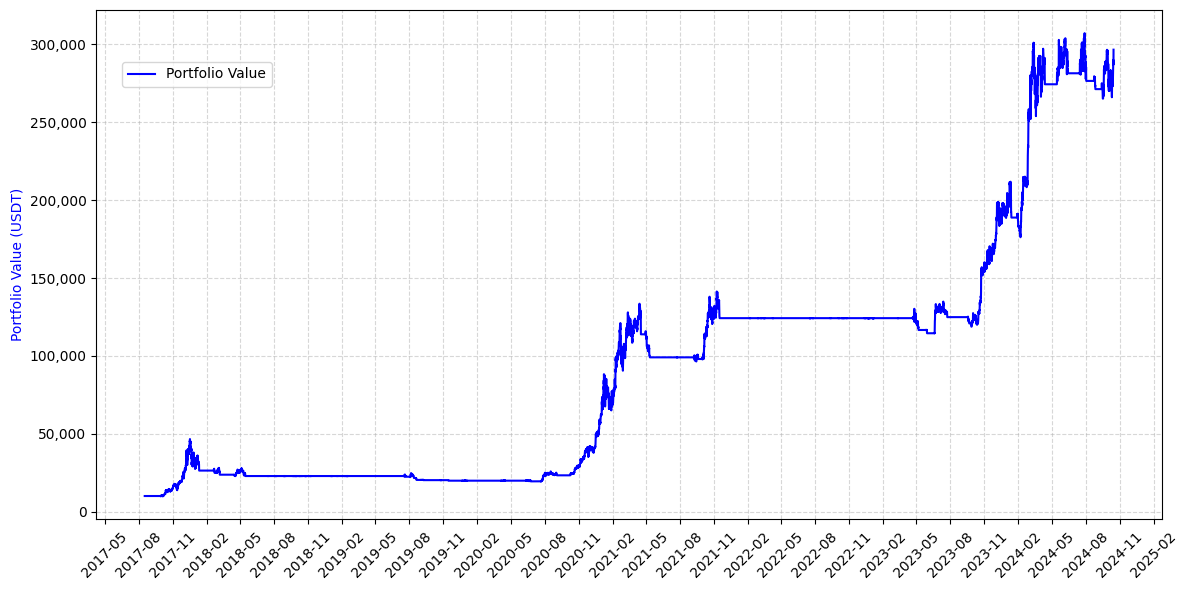

In [94]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the portfolio value over time on the left y-axis
ax1.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value', color='blue')

# Set x-axis ticks to show every 3 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set the y-axis label for portfolio value
ax1.set_ylabel('Portfolio Value (USDT)', color='blue')

# Format y-axis tick labels with commas on the left axis
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Enable grid for left axis
ax1.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis that shares the same x-axis
# ax2 = ax1.twinx()

# Plot the BTC close price on the right y-axis
# ax2.plot(btc_data['timestamp'], btc_data['close'], label='BTC Close Price', color='orange', linestyle='--')
# ax2.set_ylabel('BTC Close Price (USDT)', color='orange')
# ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Add a legend for both plots
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

## Find Best 1d MA

In [96]:
ma = 260
rsi = 80
portfolio_value_by_1d_ma = {}

for ma_1d in ma_1d_candidates:
    profit_df = backtest_and_calculate_profit(btc_data, ma, rsi, ma_1d)
    portfolio_value = profit_df['portfolio_value'].iloc[-1]
    portfolio_value_by_1d_ma[ma_1d] = portfolio_value

for ma_1d, value in portfolio_value_by_1d_ma.items():
    print(f"Final value for ma 1d {ma_1d}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma_1d = max(portfolio_value_by_1d_ma, key=portfolio_value_by_1d_ma.get)
best_value = portfolio_value_by_1d_ma[best_ma_1d]

print(f"The best performing for {interval} {ma} MA, RSI {rsi} is {best_ma_1d}MA with a final portfolio value of {best_value:,.2f} USDT")


Base portfilio value: 155,337.83 USDT
2017-09-29 08:00:00: Bought BTC at 4,220.01, holding 2.3697 BTC (RSI: 68.24)
2017-10-05 00:00:00: Sold BTC at 4,143.04, now holding 9,817.61 USDT (RSI: 28.43)

2017-10-05 04:00:00: Bought BTC at 4,154.10, holding 2.3634 BTC (RSI: 31.57)
2017-12-30 12:00:00: Sold BTC at 12,313.99, now holding 29,102.31 USDT (RSI: 35.31)

2017-12-30 16:00:00: Bought BTC at 13,040.00, holding 2.2318 BTC (RSI: 45.51)
2017-12-30 20:00:00: Sold BTC at 12,440.01, now holding 27,763.27 USDT (RSI: 36.98)

2017-12-31 00:00:00: Bought BTC at 12,962.06, holding 2.1419 BTC (RSI: 43.91)
2017-12-31 04:00:00: Sold BTC at 12,797.46, now holding 27,410.72 USDT (RSI: 38.61)

2017-12-31 08:00:00: Bought BTC at 12,989.94, holding 2.1101 BTC (RSI: 34.86)
2018-01-09 20:00:00: Sold BTC at 14,400.00, now holding 30,386.15 USDT (RSI: 29.85)

2018-01-10 20:00:00: Bought BTC at 14,907.09, holding 2.0384 BTC (RSI: 57.53)
2018-01-11 00:00:00: Sold BTC at 12,920.00, now holding 26,335.73 USDT (R

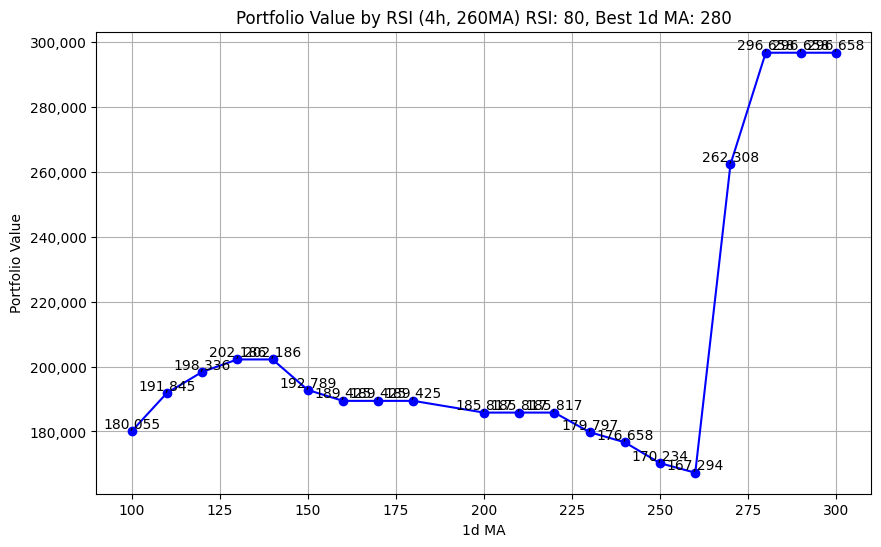

In [97]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming portfolio_value_by_ma is your dictionary
# The keys are the MA values and the values are the corresponding portfolio values

# Extracting the keys and values from the dictionary
ma_values = list(portfolio_value_by_1d_ma.keys())
portfolio_values = list(portfolio_value_by_1d_ma.values())

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(ma_values, portfolio_values, marker='o', linestyle='-', color='b')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('1d MA')
plt.ylabel('Portfolio Value')
plt.title(f'Portfolio Value by RSI ({interval}, {ma}MA) RSI: {rsi}, Best 1d MA: {best_ma_1d}')

# Displaying the plot
plt.grid(True)
plt.show()

## Find best RSI

In [104]:
ma = 260
portfolio_value_by_rsi = {}

for rsi in range(60, 100):
    profit_df = backtest_and_calculate_profit(btc_data, ma, rsi, 100)
    portfolio_value = profit_df['portfolio_value'].iloc[-1]
    # print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")
    portfolio_value_by_rsi[rsi] = portfolio_value


Base portfilio value: 155,337.83 USDT
2017-10-05 04:00:00: Bought BTC at 4,154.10, holding 2.4073 BTC (RSI: 31.57)
2017-12-30 12:00:00: Sold BTC at 12,313.99, now holding 29,642.98 USDT (RSI: 35.31)

2017-12-30 16:00:00: Bought BTC at 13,040.00, holding 2.2732 BTC (RSI: 45.51)
2017-12-30 20:00:00: Sold BTC at 12,440.01, now holding 28,279.06 USDT (RSI: 36.98)

2017-12-31 00:00:00: Bought BTC at 12,962.06, holding 2.1817 BTC (RSI: 43.91)
2017-12-31 04:00:00: Sold BTC at 12,797.46, now holding 27,919.96 USDT (RSI: 38.61)

2017-12-31 08:00:00: Bought BTC at 12,989.94, holding 2.1494 BTC (RSI: 34.86)
2018-01-09 20:00:00: Sold BTC at 14,400.00, now holding 30,950.67 USDT (RSI: 29.85)

2018-01-10 20:00:00: Bought BTC at 14,907.09, holding 2.0762 BTC (RSI: 57.53)
2018-01-11 00:00:00: Sold BTC at 12,920.00, now holding 26,825.00 USDT (RSI: 27.78)

2018-02-19 12:00:00: Bought BTC at 11,171.71, holding 2.4012 BTC (RSI: 59.15)
2018-02-21 12:00:00: Sold BTC at 10,540.31, now holding 25,308.91 USDT

In [71]:
for rsi, value in portfolio_value_by_rsi.items():
    print(f"Final value for rsi {rsi}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_rsi = max(portfolio_value_by_rsi, key=portfolio_value_by_rsi.get)
best_value = portfolio_value_by_rsi[best_rsi]

print(f"The best performing for {interval} {ma} MA is RSI {best_rsi} with a final portfolio value of {best_value:,.2f} USDT")


NameError: name 'portfolio_value_by_rsi' is not defined

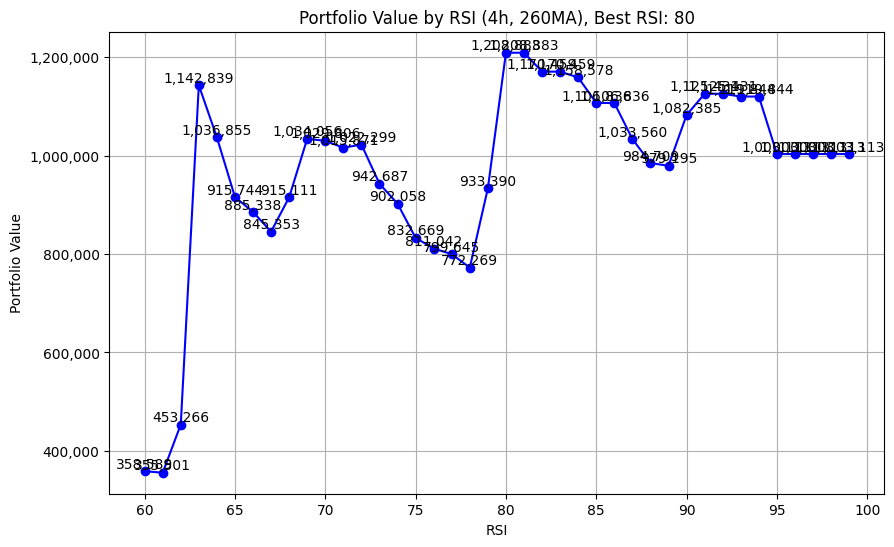

In [106]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming portfolio_value_by_ma is your dictionary
# The keys are the MA values and the values are the corresponding portfolio values

# Extracting the keys and values from the dictionary
ma_values = list(portfolio_value_by_rsi.keys())
portfolio_values = list(portfolio_value_by_rsi.values())

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(ma_values, portfolio_values, marker='o', linestyle='-', color='b')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('RSI')
plt.ylabel('Portfolio Value')
plt.title(f'Portfolio Value by RSI ({interval}, {ma}MA), Best RSI: {best_rsi}')

# Displaying the plot
plt.grid(True)
plt.show()

## Test all MA candidates using Best RSI

In [93]:
best_rsi = 80
portfolio_value_by_ma = {}
# ma_candidates = [210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
# ma_candidates = [450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560]
for ma in ma_candidates:
    profit = backtest_and_calculate_profit(bull_market_df, ma, best_rsi, 100)
    portfolio_value_by_ma[ma] = profit['portfolio_value'].iloc[-1]

Base portfilio value: 127,780.83 USDT
2020-04-06 00:00:00: Bought BTC at 7,329.90, holding 1.3643 BTC (RSI: 64.39)
2020-06-11 00:00:00: Sold BTC at 9,280.40, now holding 12,661.02 USDT (RSI: 45.69)

2020-06-12 00:00:00: Bought BTC at 9,465.13, holding 1.3376 BTC (RSI: 50.55)
2020-06-14 00:00:00: Sold BTC at 9,342.10, now holding 12,496.45 USDT (RSI: 48.28)

2020-06-16 00:00:00: Bought BTC at 9,525.59, holding 1.3119 BTC (RSI: 50.21)
2020-06-18 00:00:00: Sold BTC at 9,386.32, now holding 12,313.74 USDT (RSI: 38.17)

2020-06-22 00:00:00: Bought BTC at 9,685.69, holding 1.2713 BTC (RSI: 47.54)
2020-06-24 00:00:00: Sold BTC at 9,296.49, now holding 11,818.94 USDT (RSI: 36.75)

2020-07-08 00:00:00: Bought BTC at 9,436.06, holding 1.2525 BTC (RSI: 54.75)
2020-07-09 00:00:00: Sold BTC at 9,232.43, now holding 11,563.89 USDT (RSI: 49.48)

2020-07-21 00:00:00: Bought BTC at 9,390.00, holding 1.2315 BTC (RSI: 55.98)
2020-09-02 00:00:00: Sold BTC at 11,388.54, now holding 14,025.11 USDT (RSI: 43.

In [94]:
print (f"interval: {interval}")
print (f"Best RSI: {best_rsi}")
for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} RSI {best_rsi} is {best_ma} MA and with a final portfolio value of {best_value:,.2f} USDT")


interval: 1d
Best RSI: 80
Final value for MA 40: 66,898.81 USDT
Final value for MA 50: 74,480.88 USDT
Final value for MA 60: 72,498.84 USDT
Final value for MA 70: 65,060.66 USDT
Final value for MA 80: 67,084.13 USDT
Final value for MA 90: 52,845.22 USDT
Final value for MA 100: 53,147.73 USDT
Final value for MA 110: 55,501.14 USDT
Final value for MA 120: 57,128.33 USDT
Final value for MA 130: 10,000.00 USDT
Final value for MA 140: 10,000.00 USDT
Final value for MA 150: 10,000.00 USDT
Final value for MA 160: 10,000.00 USDT
Final value for MA 170: 10,000.00 USDT
Final value for MA 180: 10,000.00 USDT
Final value for MA 190: 10,000.00 USDT
Final value for MA 200: 10,000.00 USDT
The best performing for 1d RSI 80 is 50 MA and with a final portfolio value of 74,480.88 USDT


In [ ]:
# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}, {best_ma}MA, RSI: {best_rsi}', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at 145,580.15
plt.axhline(y=145580.15, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()
